# Customer Segmentation for a shopping app

## Problem statement

building an AI feature for a shopping app that automatically segments customers into different groups so marketing can:

    Target premium buyers

    Offer discounts to budget buyers

    Recognize churn risk customers early



### Load and clean data

In [29]:
import pandas as pd

# Load dataset
url = "https://gist.githubusercontent.com/pravalliyaram/5c05f43d2351249927b8a3f3cc3e5ecf/raw/8bd6144a87988213693754baaa13fb204933282d/Mall_Customers.csv"
df = pd.read_csv(url)

# Peek at the data
# print(df.head())
print("\nShape of the dataset:", df.shape)
print("\nSummary statistics:\n", df.describe())

df.drop("CustomerID", axis=1, inplace=True)
df.dropna(inplace=True)

df = pd.get_dummies(df, columns=["Gender"], drop_first=True)
print(df.head())


Shape of the dataset: (200, 5)

Summary statistics:
        CustomerID         Age  Annual Income (k$)  Spending Score (1-100)
count  200.000000  200.000000          200.000000              200.000000
mean   100.500000   38.850000           60.560000               50.200000
std     57.879185   13.969007           26.264721               25.823522
min      1.000000   18.000000           15.000000                1.000000
25%     50.750000   28.750000           41.500000               34.750000
50%    100.500000   36.000000           61.500000               50.000000
75%    150.250000   49.000000           78.000000               73.000000
max    200.000000   70.000000          137.000000               99.000000
   Age  Annual Income (k$)  Spending Score (1-100)  Gender_Male
0   19                  15                      39         True
1   21                  15                      81         True
2   20                  16                       6        False
3   23                  

### Data Visualization

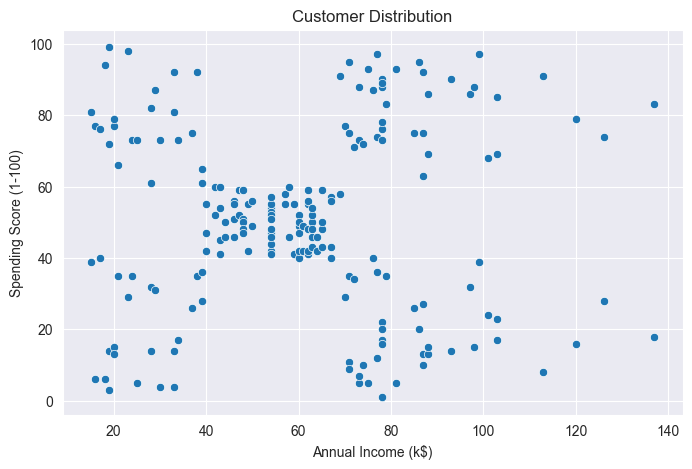

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.scatterplot(x='Annual Income (k$)', y='Spending Score (1-100)', data=df)
plt.title("Customer Distribution")
plt.xlabel("Annual Income (k$)")
plt.ylabel("Spending Score (1-100)")
plt.grid(True)
plt.show()


### KMean elbow method

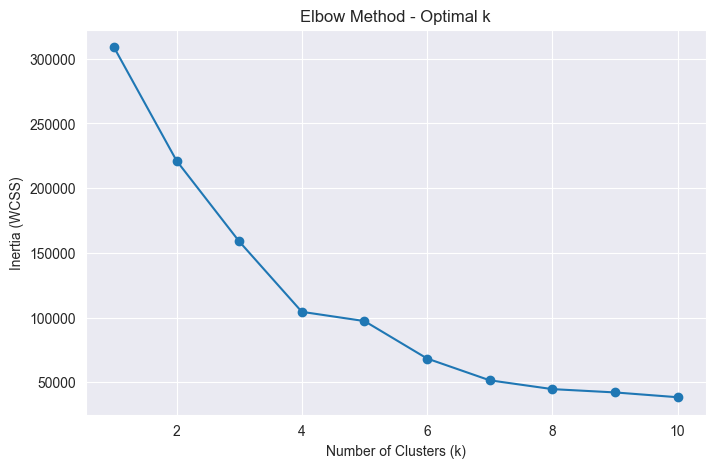

In [30]:
from sklearn.cluster import KMeans

inertia = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df)
    inertia.append(kmeans.inertia_)

# Plot the elbow
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o')
plt.title("Elbow Method - Optimal k")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia (WCSS)")
plt.grid(True)
plt.show()


### Applying KMeans with k=4

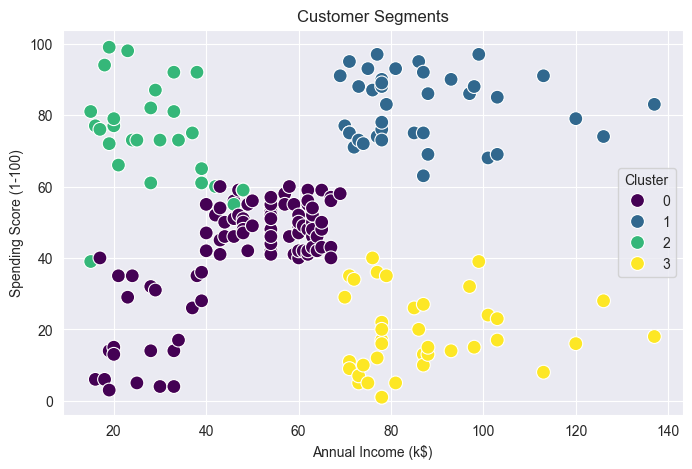

In [52]:
df.drop("Cluster", axis=1, inplace=True)
kmeans = KMeans(n_clusters=4, random_state=42)
df['Cluster'] = kmeans.fit_predict(df)

plt.figure(figsize=(8, 5))
sns.scatterplot(
    x='Annual Income (k$)', y='Spending Score (1-100)',
    hue='Cluster', palette='viridis', data=df, s=100
)
plt.title("Customer Segments")
plt.xlabel("Annual Income (k$)")
plt.ylabel("Spending Score (1-100)")
plt.grid(True)
plt.show()


### Feature selection & Scaling

In [54]:
from sklearn.preprocessing import StandardScaler

features = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)', 'Gender_Male']

X = df[features]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(X_scaled)
df['Cluster'] = kmeans.labels_


print(df.groupby('Cluster')[features].mean())



               Age  Annual Income (k$)  Spending Score (1-100)  Gender_Male
Cluster                                                                    
0        56.470588           46.098039               39.313725     0.509804
1        39.500000           85.150000               14.050000     1.000000
2        28.690476           60.904762               70.238095     1.000000
3        37.897959           82.122449               54.448980     0.000000
4        27.315789           38.842105               56.210526     0.000000


### Visulaize

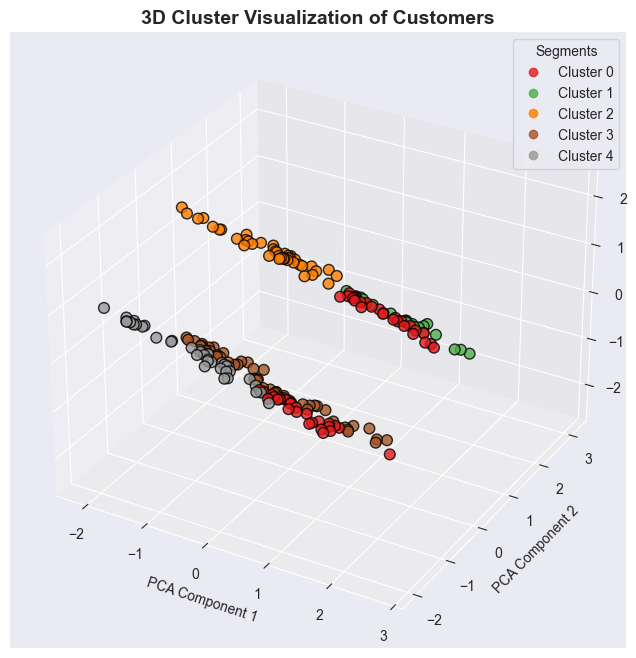

In [64]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)



fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(
    X_pca[:, 0], X_pca[:, 1], X_pca[:, 2],
    c=df['Cluster'], cmap='Set1', s=60, alpha=0.8, edgecolor='k'
)

ax.set_title('3D Cluster Visualization of Customers', fontsize=14, fontweight='bold')
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')

# Legend
legend_labels = [f'Cluster {i}' for i in range(5)]
legend = ax.legend(handles=scatter.legend_elements()[0], labels=legend_labels, title="Segments")
plt.show()


In [65]:
for i in range(5):
    print(f"\nCluster {i} Summary:\n", df[df['Cluster'] == i][features].describe())



Cluster 0 Summary:
              Age  Annual Income (k$)  Spending Score (1-100)
count  51.000000           51.000000               51.000000
mean   56.470588           46.098039               39.313725
std     8.582198           14.006077               17.324538
min    37.000000           19.000000                3.000000
25%    49.000000           38.500000               30.500000
50%    55.000000           47.000000               46.000000
75%    65.000000           57.500000               51.500000
max    70.000000           75.000000               60.000000

Cluster 1 Summary:
              Age  Annual Income (k$)  Spending Score (1-100)
count  20.000000           20.000000               20.000000
mean   39.500000           85.150000               14.050000
std    12.550949           16.030481                9.566801
min    19.000000           71.000000                1.000000
25%    32.750000           76.250000                8.750000
50%    41.000000           79.500000       

### New Customer testing

In [66]:
# Predict segment of new customer
new_customer = pd.DataFrame([{
    'Age': 32,
    'Annual Income (k$)': 65,
    'Spending Score (1-100)': 78,
    'Gender_Male': 1
}])

# Scale using same scaler
new_customer_scaled = scaler.transform(new_customer[features])

# Predict cluster
predicted_cluster = kmeans.predict(new_customer_scaled)[0]
print("✅ Predicted Segment (Cluster):", predicted_cluster)


✅ Predicted Segment (Cluster): 2


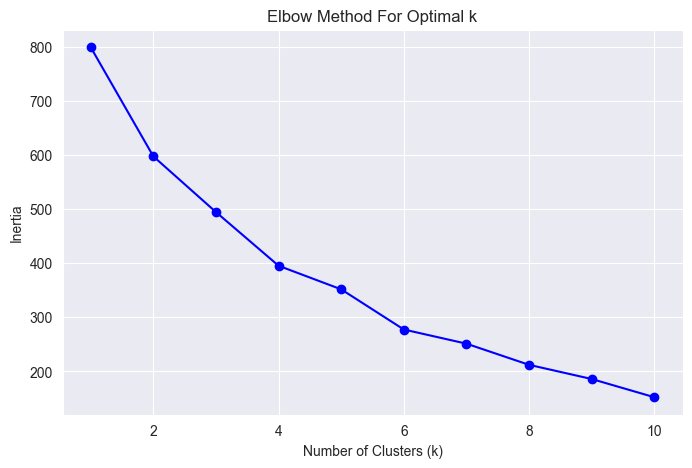

In [53]:
# Find optimal k using inertia
inertia = []
K = range(1, 11)

for k in K:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    inertia.append(km.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 5))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.grid(True)
plt.show()


In [68]:
for i, component in enumerate(pca.components_):
    print(f"\n📌 PCA {i+1}")
    for feature, weight in zip(features, component):
        print(f"{feature:24s}: {weight:.4f}")


📌 PCA 1
Age                     : 0.6879
Annual Income (k$)      : -0.0061
Spending Score (1-100)  : -0.6869
Gender_Male             : 0.2343

📌 PCA 2
Age                     : -0.1037
Annual Income (k$)      : 0.7653
Spending Score (1-100)  : 0.1032
Gender_Male             : 0.6269

📌 PCA 3
Age                     : -0.1224
Annual Income (k$)      : -0.6437
Spending Score (1-100)  : 0.1366
Gender_Male             : 0.7430
